In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)

from helper_functions import *

import pandas as pd
from glob import glob
import os


import matplotlib
import matplotlib.pyplot as plt
import PIL
from PIL import Image

from torchvision import transforms
from torch.utils.data import DataLoader

from tqdm.notebook import tqdm

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchinfo
import torchvision

from torchinfo import summary


import multiprocessing

In [ ]:
import sys
from collections import Counter

import cv2

import numpy as np

import sklearn

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from torchvision import datasets, transforms


from tqdm.version import __version__ as tqdm__version__

torch.backends.cudnn.deterministic = True

# 1.  EDA

In [3]:
# now that we have test_fearure.zip and and test_feature.csv, we'll have a look at the both of them see if the have same features
# data_path = os.path.join(os.getcwd())

parent_dir = os.path.dirname(os.getcwd())
data_dir = os.path.join(parent_dir, 'competition_host_files', 'data')
print(f'Folder containing all data: {data_dir}\nfiles in the folder: \n{os.listdir(data_dir)}')

Folder containing all data: c:\Users\LENOVO\Desktop\Wildlife_Image_Classification\competition_host_files\data
files in the folder: 
['test_features', 'test_features.csv', 'train_features', 'train_features.csv', 'train_labels.csv']


In [4]:
train_df = pd.read_csv(os.path.join(data_dir, 'train_features.csv'),index_col='id')
test_df = pd.read_csv(os.path.join(data_dir, 'test_features.csv'),index_col='id')
train_labels_df = pd.read_csv(os.path.join(data_dir, 'train_labels.csv'),index_col='id')

In [5]:
train_df.head()

,filepath,site
id,,
ZJ000000,train_features/ZJ000000.jpg,S0120
ZJ000001,train_features/ZJ000001.jpg,S0069
ZJ000002,train_features/ZJ000002.jpg,S0009
ZJ000003,train_features/ZJ000003.jpg,S0008
ZJ000004,train_features/ZJ000004.jpg,S0036


In [6]:
test_df.head()

,filepath,site
id,,
ZJ016488,test_features/ZJ016488.jpg,S0082
ZJ016489,test_features/ZJ016489.jpg,S0040
ZJ016490,test_features/ZJ016490.jpg,S0040
ZJ016491,test_features/ZJ016491.jpg,S0041
ZJ016492,test_features/ZJ016492.jpg,S0040


In [7]:
train_labels_df.head()

,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
id,,,,,,,,
ZJ000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
ZJ000001,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
ZJ000002,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
ZJ000003,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
ZJ000004,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


## We'll march each image to it's label

In [8]:
id_species = {}
for idx , labels in train_labels_df.iterrows():
    condition = (labels == 1)

    id_species[idx] = labels[condition].index.to_list()[0]

id_species_df = pd.DataFrame.from_dict(id_species, orient='index')
id_species_df.columns = ['species']
id_species_df.index.name = 'id'

# join the 2 df
combined_df = train_df.join(id_species_df)

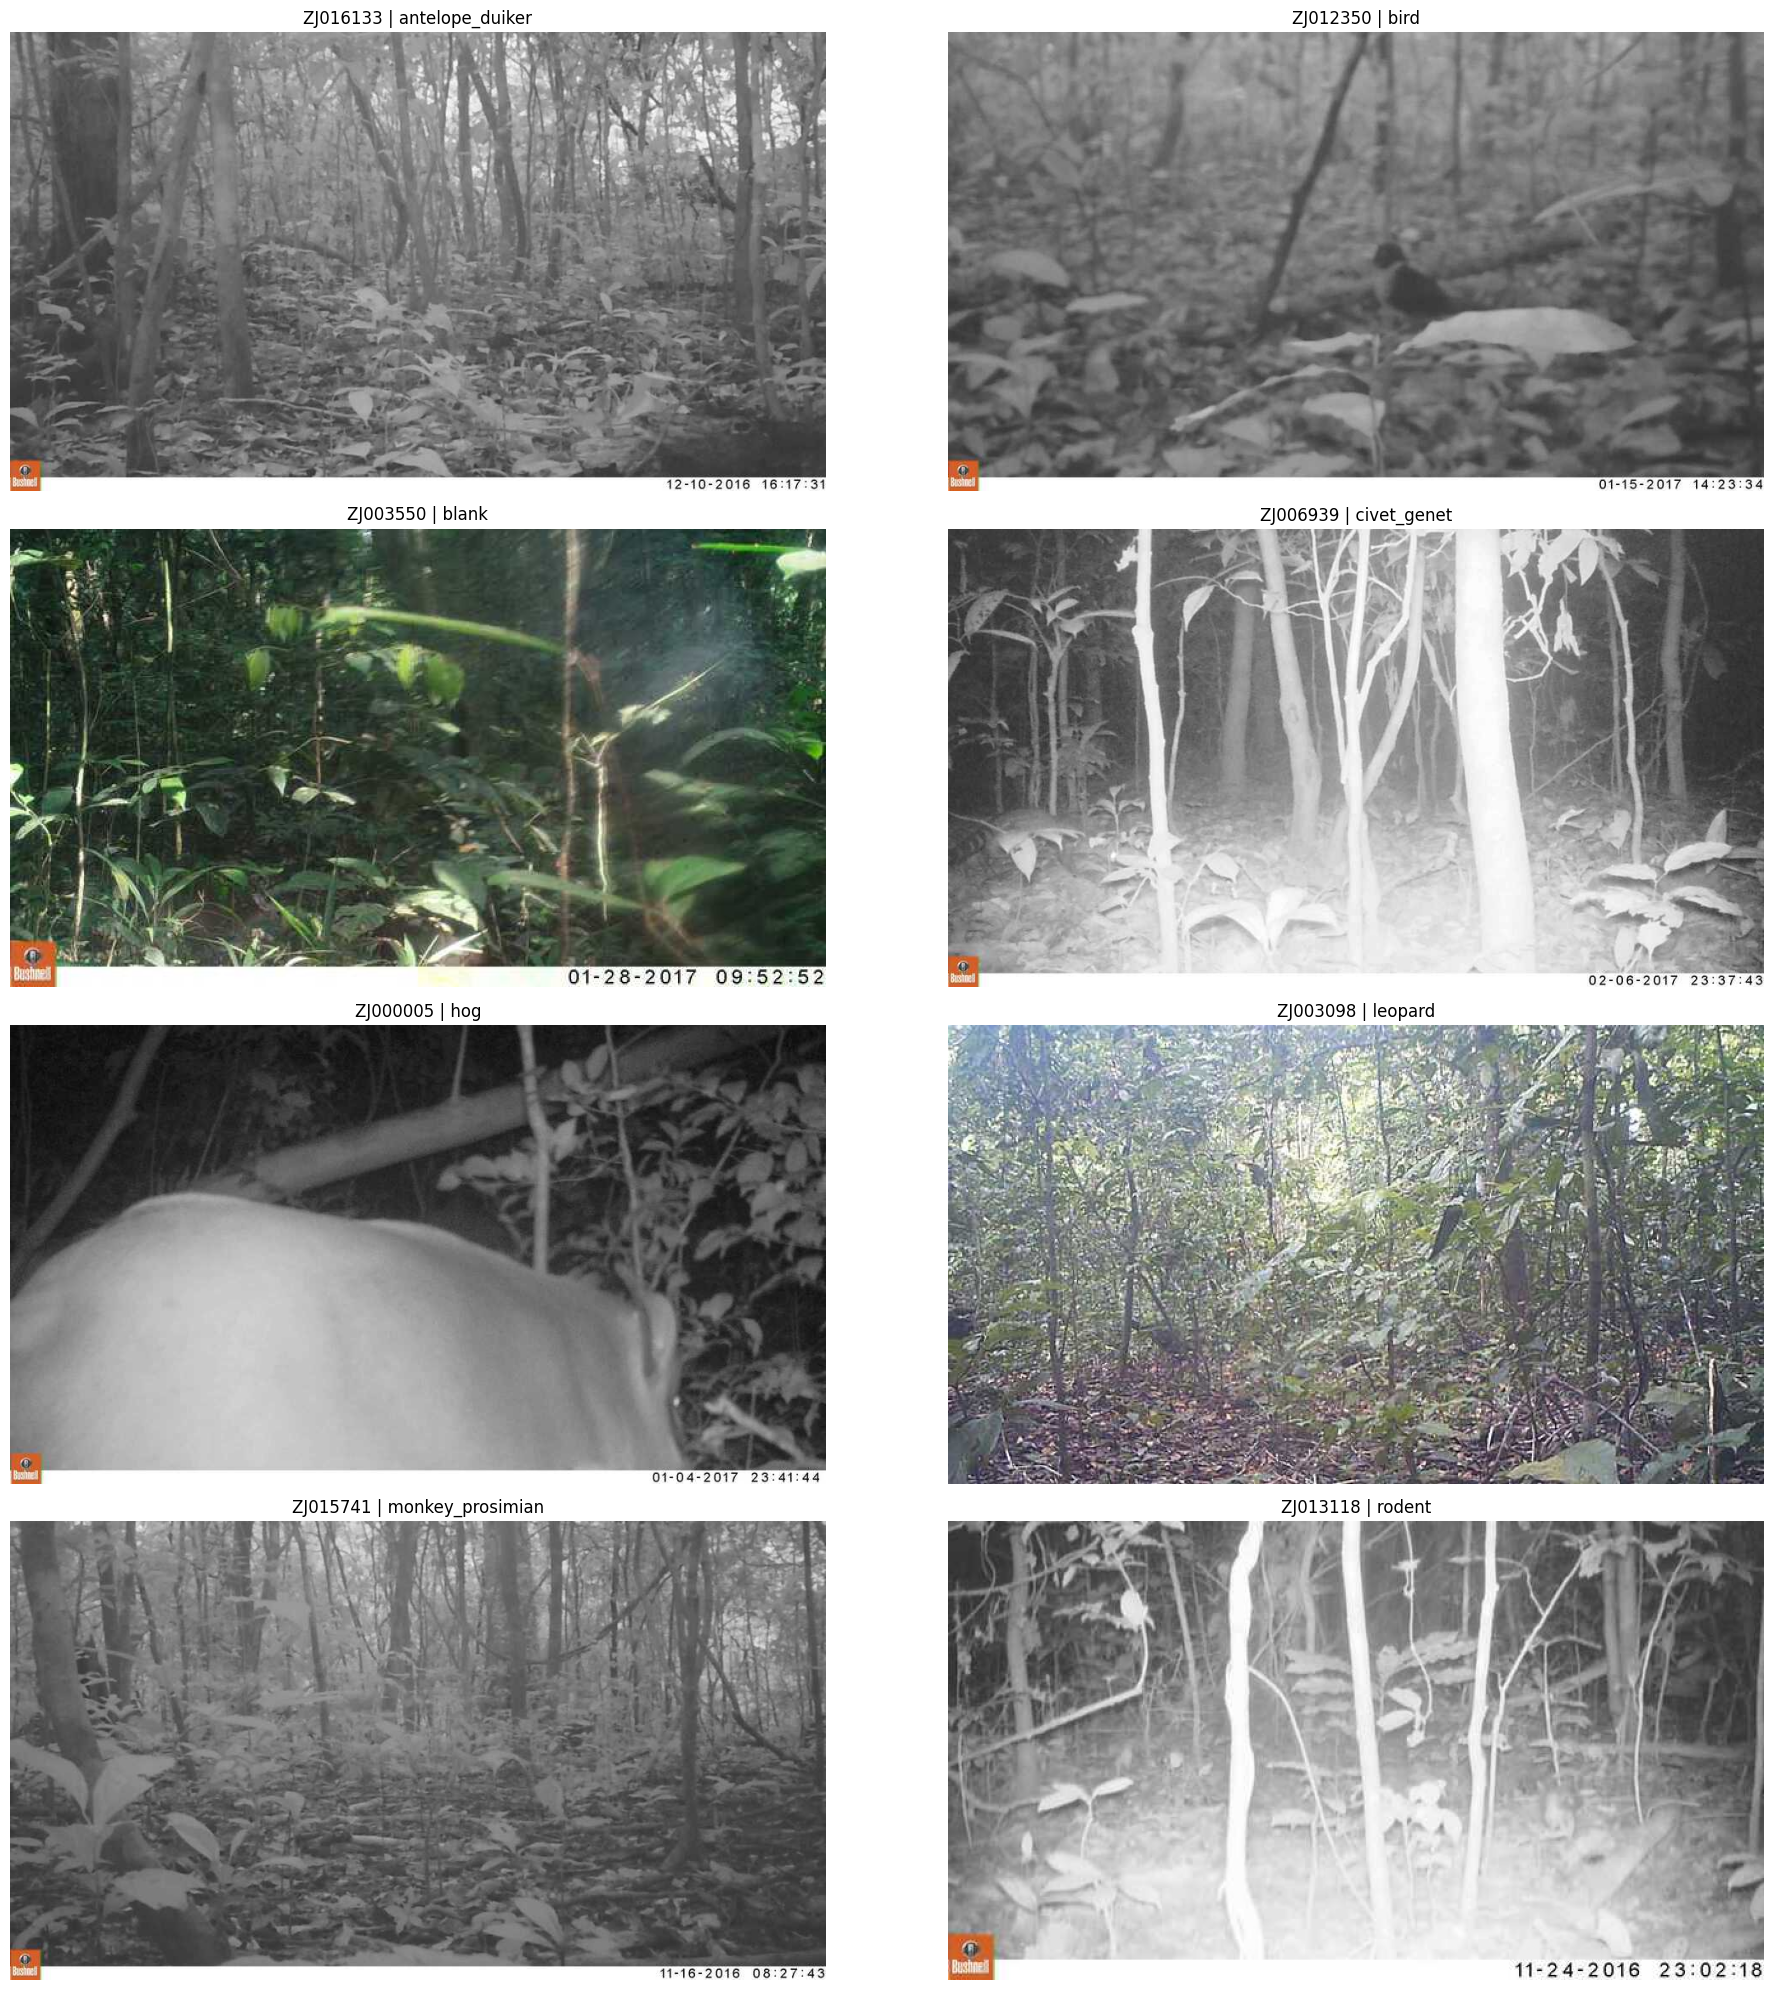

In [9]:
# Well plot an image of each species 
species = train_labels_df.columns.to_list()

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20, 20))
for ax, sps in zip(axes.flatten(), species):
    # get a random row for each specie
    random_row = combined_df[combined_df.loc[:, :]['species']==sps].sample(1, random_state=None)
    img_id= random_row.index[0]
    filepath = os.path.join(data_dir , random_row['filepath'][0])
    img =Image.open(filepath)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"{img_id} | {sps}")

plt.tight_layout()
plt.show()

## Data distribution


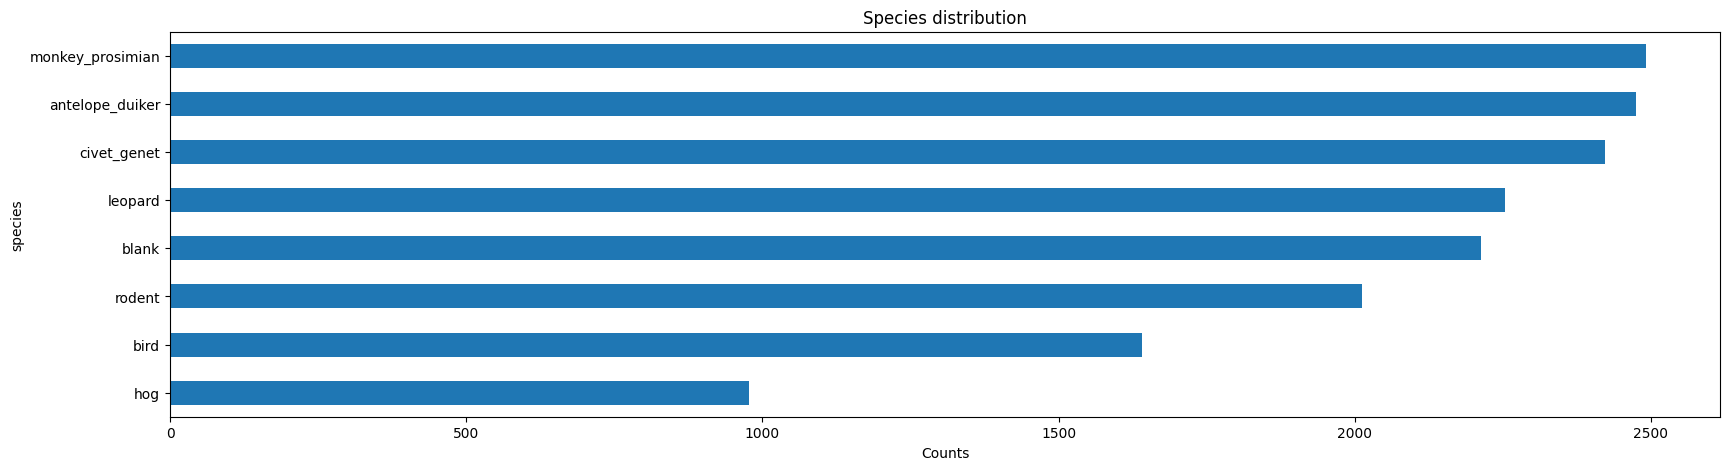

In [10]:
def species_distribution (df):
    plt.figure(figsize = (20, 5))

    df['species'].value_counts().sort_values().plot(kind="barh");
    plt.xlabel("Counts")
    plt.title('Species distribution')
species_distribution(combined_df)

FOR THE PURPOSE OF LEARNING, I'LL JUST PICK 2 OF THE HIGHEST SPECIES PLUS OUR MACHINE HAS NO GPU

In [11]:
combined_df.head(3)

,filepath,site,species
id,,,
ZJ000000,train_features/ZJ000000.jpg,S0120,bird
ZJ000001,train_features/ZJ000001.jpg,S0069,monkey_prosimian
ZJ000002,train_features/ZJ000002.jpg,S0009,bird


In [12]:
# create a combined_df with only the 2 species
def bi_species(df):
    return df['species'].value_counts().sort_values(ascending=False).iloc[:2].index.to_list()
bi_species_ = bi_species(combined_df)

filtered_df = combined_df[combined_df['species'].isin(bi_species_)]

print(f'Species: {bi_species_} \nShape: {filtered_df.shape} \n\nFeature value_counts: {filtered_df["species"].value_counts()}')

Species: ['monkey_prosimian', 'antelope_duiker'] 
Shape: (4966, 3) 

Feature value_counts: species
monkey_prosimian    2492
antelope_duiker     2474
Name: count, dtype: int64


In [13]:
# shuffle dataset
filtered_df.sample(frac=1)

filtered_df_test = filtered_df.iloc[int(len(filtered_df) * 0.8):]
filtered_df_train_val = filtered_df.iloc[0:int(len(filtered_df) * 0.8)]

assert len(filtered_df) == (len(filtered_df_train_val) + len(filtered_df_test))

# filtered_df_train =  filtered_df_train_val.iloc[0:int(len(filtered_df_train_val) * 0.8)]
# filtered_df_val = filtered_df_train_val.iloc[int(len(filtered_df_train_val) * 0.8):]

# assert len(filtered_df_train_val) == (len(filtered_df_val) + len(filtered_df_train))



This is subject to correction but from my understanding of image datasets used for training a machinelearning model,

<span style="background-color: blue;">THE DATASET:</span>

Should be an object that behaves like a list of tuples, where each tuple containes an image and its label or  encodding..

- `An image (PIL Image by default)`
- `Its corresponding label or encoding`

Below we'll manually create a dataset using the dataframe we created earlier.

We'll further create a dataloader that will be used to load the dataset in batches during training.

In [29]:
class ConvertToRGB:
    def __call__(self, img):
        if img.mode != "RGB":
            img = img.convert("RGB")
        return img

transform = transforms.Compose([
    ConvertToRGB(),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

def create_dataset(df, data_dir, transform):
    label_to_idx = {}
    for idx, label in enumerate(df['species'].unique()):
        label_to_idx[label] = idx

    dataset = []
    for i in tqdm(range(len(df))):
        filepath =os.path.join(data_dir, df.iloc[i]['filepath'])
        img = Image.open(filepath)
        transformed_img=transform(img)

        # encode data
        df['species'] = df['species'].replace(label_to_idx)
        label = df.iloc[i]['species']
        dataset.append((transformed_img, label))

    return dataset

dataset = create_dataset(filtered_df_train_val, data_dir, transform=transform)


train_loader = DataLoader(dataset, batch_size=32, shuffle=True)
print(f'train_loader created successfully')

  0%|          | 0/3972 [00:00<?, ?it/s]

train_loader created successfully


In [23]:
print(os.getcwd())

c:\Users\LENOVO\Desktop\Wildlife_Image_Classification\analysis


Another Important concent in Image Classification is **NORMOLIZATION**
basically what normolization does is scale pixel values so they fall into a consistent range, typically around 0 with a small standard deviation. Here's why it's important:
- **Improved Model Training**: When the pixel values are normalized, the model can learn more effectively. This is because the model doesn't have to spend as much time adjusting to the scale of the input data.
- **Better Generalization**: Normalized data helps the model generalize better to new, unseen data. This is because the model is less likely to be influenced by the specific range of pixel values in the training data.
- **Reduced Overfitting**: Normalization can help reduce overfitting, which is when a model learns to fit the training data too closely, leading to poor performance on new data.
- **Better Interpretability**: Normalized data can make it easier to interpret the model's decisions, as the pixel values are on a more consistent scale.
- **Pretrained Models Expect It**: If you're using a model like ResNet or VGG (from torchvision.models), they were trained on ImageNet with specific normalization values:

 
I've added a function in [helper_function.py](helper_functions.py) with the code that calculated the mean and standard deviation of the training data.

Below I've given an explanation of how the standard deviation is calculated, since it's not a straigforward concept.


The standard deviation ($\sigma$) of a population is calculated using the formula:
$$\text{std} = \sqrt{\frac{\sum_{i=1}^{N}(x_i - \mu)^2}{N}}$$

$OR$

$$\text{std} = \sqrt{\frac{1}{N} \sum_{i=1}^{N} (x_i - \mu)^2}$$


where:
- $N$ is the number of data points in the population.
- $x_i$ is each individual data point.
- $\mu$ is the population mean.


$THE$ $ABOVE$ $FORMULAS$ $CAN$ $ALSO$ $BE$ $EXPRESSED  AS:$

$$\text{std} = \sqrt{\frac{1}{N} \sum_{i=1}^{N} x_i^2 - \mu^2}$$


Where:

* $\sum_{i=1}^{N} x_i^2$ is the **sum of squared values** .

* $\frac{1}{N} \sum_{i=1}^{N} x_i^2$ **mean of the squared values**

* $\mu^2$ is the **square of the mean** .

In Laymans term **STD**:

Is the **squaroot** of * **mean of the squared values** - **square of the mean**

<span style="background-color: red;">NOTE:</span>

From the above explanation: 

**mean of the squared values** - **square of the mean** gives us `VARIANCE`


🤔🤔Intresting isn't it:

We'll use a simple example to explain this say we have an array of number `[1, 2, 3, 4]`

In [ ]:
mean, std = get_mean_std(train_loader )

Computing mean and std: 0it [00:00, ?it/s]

After creating our getting our mean we'll create a new transform to normalize the data

In [31]:
norm_transform = transforms.Compose(
    [
    ConvertToRGB(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
    ]

)

dataset = create_dataset(filtered_df_train_val, data_dir, transform=norm_transform)
norm_train_loader = DataLoader(dataset, batch_size=32, shuffle=True)
print(f'train_loader created successfully')

  0%|          | 0/3972 [00:00<?, ?it/s]

train_loader created successfully
